# setup enviroment

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torcheval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.5 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Learning/data_science/')



# Accelerated SGD

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## Optimizers

finds the optimum learning rate.
<br>the learning rate is used to step in the direction that gradient decent points
<br>too far and you could over shoot the optimum setting
<br>too little and training takes for ever.

### SGD

In [ ]:
# SGD estimates the gradient using just a single data point or a small batch of data points at each iteration.
# This makes SGD faster and more computationally efficient
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    # Called each training iteration to update the parametersg
    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    # Zeros out the gradient for all parameters.
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
# adam is a comparison between Adam and
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.796,0.574,0,train
0.843,0.433,0,eval
0.868,0.363,1,train
0.867,0.373,1,eval
0.884,0.318,2,train
0.875,0.349,2,eval


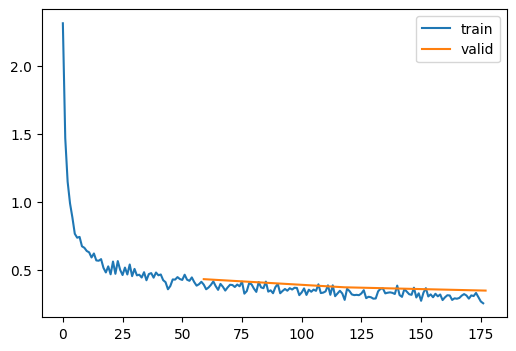

In [ ]:
#| label: fig-polar
#| echo: True
#| fig-cap: "A line plot on a polar axis"
#| code-fold : True

set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

Adam with Automatic Annealer<br><br>
Automatic annealing refers to the automatic adjustment of the learning rate during training. Unlike a constant or step-wise decayed learning rate, automatic annealers adjust the learning rate based on the model's performance, generally on the validation set. Criteria such as validation loss, training loss, or some other metric can be used for this adjustment.
<br><br>
For instance, if the validation loss plateaus or increases, the annealer may reduce the learning rate, effectively "cooling down" the optimization and allowing the model to escape local minima or saddle points. Conversely, if the model is learning effectively, the annealer might maintain or even slightly increase the learning rate.